# Constrained MDP (CMDP)

<!-- #行列からやる -->
---

今回はCMDPを考えたアルゴリズムの中でもOpt_CMDPというアルゴリズムを考えます．



In [1]:
# 環境の定義

import numpy as np

states = np.arange(0,3)
actions = {0:[0,1],1:[0,1],2:[0,1]} # 0:遷移しない, 1:遷移する

S = len(states)
A = 2

#遷移確率と報酬とコストを定義
P  = np.zeros((S, A, S))
R = np.zeros((S, A))
C = np.zeros((S, A))

for s in range(S):
    for a in range(A):

        if a == 0:
            P[s,a,s] = 1
        else:
            R[s,a] = -(s + 1)
            C[s,a] = 1

            if s < S-1:
                P[s,a,s+1] = 1
            else:
                P[s,a,0] = 1
             
#報酬の絶対値の大きさを1以下にする
for s in range(S):
    for a in range(A):
        R[s][a] = R[s][a]/3

print(R)
print(C)
print(P)

states_abs = np.arange(0,1)
nA_abs = 2


N_STATES_abs = len(states_abs)

P_abs = np.zeros((1,2,1))
R_abs = np.zeros((1,2))
C_abs = np.zeros((1,2))

P_abs[0][0][0] = 1
P_abs[0][1][0] = 1

R_abs[0][1] = 2

C_abs[0][1] = 1



[[ 0.         -0.33333333]
 [ 0.         -0.66666667]
 [ 0.         -1.        ]]
[[0. 1.]
 [0. 1.]
 [0. 1.]]
[[[1. 0. 0.]
  [0. 1. 0.]]

 [[0. 1. 0.]
  [0. 0. 1.]]

 [[0. 0. 1.]
  [1. 0. 0.]]]


In [2]:
EPISODE_LENGTH = 6
CONSTRAINT = EPISODE_LENGTH/2
C_b = CONSTRAINT/5
# NUMBER_EPISODES = 1e5
NUMBER_EPISODES = 1000
NUMBER_SIMULATIONS = 1

eps = 0.01
M = 0
delta = 0.01

P_hat = np.zeros((S, A, S))
R_hat = np.zeros((S, A))
C_hat = np.zeros((S, A))
Total_emp_reward = np.zeros((S, A))
Total_emp_cost = np.zeros((S ,A))

s_a_visit = np.zeros((S, A))
s_a_s_visit = np.zeros((S, A, S))
beta_prob = np.zeros((S,A,S))
beta_prob_2 = np.zeros((S,A,S))
beta_r = np.zeros((S,A))
beta_prob_T = np.zeros((S,A,S))

mu = np.zeros((S))
mu[0] = 1


In [3]:
#次の状態や報酬を返す関数   
def step(state,action):
    next_state = int(np.random.choice(np.arange(S),1,replace=True,p=P[state,action,:]))
    rew = R[state,action]
    cost = C[state,action]
    return next_state,rew,cost

#訪問回数を更新する関数
def setCounts(s_a_s_count,s_a_count):
    for s in range(S):
        for a in range(A):
            s_a_visit[s,a] += s_a_count[s,a]
            for s_ in range(S):
                s_a_s_visit[s,a,s_] += s_a_s_count[s,a,s_]

#経験的な遷移関数の更新
def update_P_hat():
    for s in range(S):
        for a in range(A):

            if s_a_visit[s][a] == 0:
                P_hat[s][a] = 1 / S * np.ones(S)
            
            else:
                for s_ in range(S):
                    P_hat[s][a][s_] = s_a_s_visit[s][a][s_] / s_a_visit[s][a]
                
                P_hat[s][a] = P_hat[s][a] / np.sum(P_hat[s][a])

#経験的な報酬とコストの更新
def update_RC_hat(emp_r,emp_c):
    for s in range(S):
        for a in range(A):
            R_hat[s][a] = (Total_emp_reward[s][a] + emp_r[s][a]) / (max(s_a_visit[s][a],1))
            C_hat[s][a] = (Total_emp_cost[s][a] + emp_c[s][a]) / (max(s_a_visit[s][a],1))

            Total_emp_reward += emp_r
            Total_emp_cost += emp_c

#信頼区間の計算
def calc_confidence_interval():
    for s in range(S):
        for a in range(A):
            beta_r[s][a] = np.sqrt(1/max(1,s_a_visit[s][a]))
            for s_ in range(S):
                beta_prob[s][a][s_] = np.sqrt(P_hat[s][a][s_]*(1-P_hat[s][a][s_])/max(s_a_visit[s][a],1)) + 1/(max(s_a_visit[s][a],1))




In [4]:
# 価値関数やコスト関数の計算
def Policy_evaluation(P,policy,R,C):
    Q_h = np.zeros((S,EPISODE_LENGTH,A))
    V_h = np.zeros((S,EPISODE_LENGTH))
    C_h = np.zeros((S,EPISODE_LENGTH))

    P_policy = np.zeros((S,EPISODE_LENGTH,S))
    R_policy = np.zeros((S,EPISODE_LENGTH))
    C_policy = np.zeros((S,EPISODE_LENGTH))


    
    for s in range(S):
        for a in range(A):
            C_h[s][EPISODE_LENGTH-1] += policy[s][EPISODE_LENGTH-1][a] * C[s][a]
            Q_h[s,EPISODE_LENGTH-1,a] = R[s][a]

        V_h[s,EPISODE_LENGTH-1] = np.dot(Q_h[s,EPISODE_LENGTH-1,:],policy[s,EPISODE_LENGTH-1,:])
    
    for h in range(EPISODE_LENGTH):
        for s in range(S):
            for a in range(A):
                C_policy[s][h] += policy[s][h][a] * C[s][a]
            
            for s_ in range(S):
                for a in range(A):
                    P_policy[s,h,s_] += policy[s][h][a] * P[s][a][s_]
    
    for h in range(EPISODE_LENGTH-2,-1,-1): #0~4
        for s in range(S):
            C_h[s,h] = C_policy[s,h] + np.dot(P_policy[s,h,:],C_h[:,h+1])
            for a in range(A):
                P_V = 0
                for s_ in range(S):
                    P_V += P_policy[s,h,s_] * V_h[s_,h+1]
                Q_h[s,h,a] = R[s][a] + P_V
            V_h[s,h] = np.dot(Q_h[s,h,:],policy[s,h,:])
    
    return Q_h,V_h,C_h


次にリグレットを計算するために最適な線形計画法の関数を作ります．(この場合の最適は制約を考えない時の問題です)

In [5]:
import pulp

def compute_optimal_LP():
    opt_policy = np.zeros((S,EPISODE_LENGTH,A))
    opt_problem = pulp.LpProblem('opt_problem',pulp.LpMinimize)
    opt_q = np.zeros((EPISODE_LENGTH,S,A))

    q_keys = [(h,s,a) for h in range(EPISODE_LENGTH) for s in range(S) for a in range(A)]
    q = pulp.LpVariable.dicts('q',q_keys,lowBound=0,upBound=1,cat='Continuous')

    list_R = [R[s][a] for s in range(S) for a in range(A)] * EPISODE_LENGTH
    list_q = [q[(h,s,a)] for h in range(EPISODE_LENGTH) for s in range(S) for a in range(A)]

    #目的関数
    opt_problem += pulp.lpDot(list_R,list_q)

    #制約条件

    for h in range(1,EPISODE_LENGTH):
        for s in range(S):
            q_list = [q[(h,s,a)] for a in range(A)]
            pq_list = [P[s_][a_][s] * q[(h-1,s_,a_)] for s_ in range(S) for a_ in range(A)]
            opt_problem += pulp.lpSum(q_list) - pulp.lpSum(pq_list) == 0
    

    for s in range(S):
        q_list = [q[(0,s,a)] for a in range(A)]
        opt_problem += pulp.lpSum(q_list) - mu[s] == 0

    
    status = opt_problem.solve(pulp.PULP_CBC_CMD(msg=False,fracGap=0.001))
    # status = opt_problem.solve()

    ##ここで最適な方策が出る．
    for h in range(EPISODE_LENGTH):
        for s in range(S):
            for a in range(A):
                opt_q[h,s,a] = q[(h,s,a)].varValue
                if np.sum(opt_q[h,s,:]) == 0:
                    opt_policy[s,h,:] = 1/A
                else:
                    opt_policy[s,h,a] = opt_q[h,s,a] / np.sum(opt_q[h,s,:])


    q_policy,value_of_policy,cost_of_policy = Policy_evaluation(P,opt_policy,R,C)
    
    return  opt_policy,q_policy,value_of_policy,cost_of_policy





---

ここからExtended LP問題を考えるのですが，この[サイト](https://qiita.com/ytakashina/items/9de38882ffa611d5a07a)からpulpの大きいモデルではnumpy.sumを避ける理由が書いてあります．


In [6]:
# CMDPを解くための線形計画法
import pulp
import math

def solve_CMDP():
    policy = np.zeros((S,EPISODE_LENGTH,A))
    problem = pulp.LpProblem('CMDP', pulp.LpMinimize)
    z_opt = np.zeros((EPISODE_LENGTH,S,A,S))
    z_keys = [(h,s,a,s_) for h in range(EPISODE_LENGTH) for s in range(S) for a in range(A) for s_ in range(S)]
    z = pulp.LpVariable.dicts('z_var',z_keys,0,1,cat='Continuous')
    
    #最適したい問題
    problem += pulp.lpSum([z[(h,s,a,s_)] * R[s][a] for h in range(EPISODE_LENGTH) for s in range(S) for a in range(A) for s_ in range(S)])

    #制約条件
    problem += pulp.lpSum([z[(h,s,a,s_)] * C[s][a] for h in range(EPISODE_LENGTH) for s in range(S) for a in range(A) for s_ in range(S)]) <= CONSTRAINT

    for h in range(1,EPISODE_LENGTH):
        for s in range(S):
            z_list = [z[(h,s,a,s_)] for a in range(A) for s_ in range(S)]
            z_prev_list = [z[(h-1,s_,a,s)] for a in range(A) for s_ in range(S)]
            problem += pulp.lpSum(z_list) == pulp.lpSum(z_prev_list)

    for s in range(S):
        z_1_lsit = [z[(0,s,a,s_)] for a in range(A) for s_ in range(S)]
        problem += pulp.lpSum(z_1_lsit) == mu[s]
    
    # problem += [z[(h,s,a,s_)] >= 0 for h in range(EPISODE_LENGTH) for s in range(S) for a in range(A) for s_ in range(S)]

    for h in range(EPISODE_LENGTH):
        for s in range(S):
            for a in range(A):
                for s_ in range(S):
                    problem += z[(h,s,a,s_)] >= 0

    for h in range(EPISODE_LENGTH):
            for s in range(S):
                for a in range(A):
                    for s_1 in range(S):
                        problem += z[(h,s,a,s_1)] - (P_hat[s][a][s_1] + beta_prob[s,a,s_1]) * pulp.lpSum([z[(h,s,a,y)] for y in range(S)]) <= 0
                        problem += -z[(h,s,a,s_1)] + (P_hat[s][a][s_1] - beta_prob[s,a,s_1])* pulp.lpSum([z[(h,s,a,y)] for y in range(S)]) <= 0

    #問題を解く
    # status = problem.solve(pulp.PULP_CBC_CMD(msg=False,fracGap=0.0001))
    status = problem.solve()

    if pulp.LpStatus[status] != 'Optimal':
        print('Not Optimal')
        return np.zeros((S,EPISODE_LENGTH,S)),np.zeros((S,EPISODE_LENGTH)),np.zeros((S, EPISODE_LENGTH)), pulp.LpStatus[status], np.zeros((S, EPISODE_LENGTH,S))
    
    for h in range(EPISODE_LENGTH):
        for s in range(S):
            for a in range(A):
                for s_ in range(S):
                    z_opt[h][s][a][s_] = z[(h,s,a,s_)].varValue

    z_s_a = np.sum(z_opt,axis=3)
    z_s = np.sum(z_opt,axis=(2,3))

    for h in range(EPISODE_LENGTH):
        for s in range(S):
            sum_probs = 0
            for a in range(A):
                policy[s,h,a] = z_s_a[h][s][a] / z_s[h][s]
                sum_probs += policy[s,h,a]
            
            if math.isnan(sum_probs):
                for a in range(A):
                    policy[s,h,a] = 1 / A
            
            else:
                for a in range(A):
                    policy[s,h,a] = policy[s,h,a] / sum_probs
    
    q_policy, value_of_policy, cost_of_policy = Policy_evaluation(P, policy,R,C)

    return policy,value_of_policy,cost_of_policy, pulp.LpStatus[status], q_policy


            




---

ここから上の関数などを使って，OptCMDPのアルゴリズムを書いていきます，


In [7]:
import matplotlib.pyplot as plt
import time
import math
import random

strat_time = time.time()

seed = 10
random.seed(seed)
np.random.seed(seed)

opt_poicy,q_opt,value_opt,cost_opt = compute_optimal_LP()
NUMBER_EPISODES = int(NUMBER_EPISODES)
#リグレットを保存
Object_Regret = np.zeros((NUMBER_EPISODES))
Cost_Regret = np.zeros((NUMBER_EPISODES))

s_a_s_count = np.zeros((S,A,S))
s_a_count = np.zeros((S,A))
objs = []
cons = []

#各エピソードの総コストを保存
NUMBER_INFEASINILITIES = np.zeros((NUMBER_EPISODES))

#ここから問題を解き始める

from tqdm import tqdm

for episode in tqdm(range(NUMBER_EPISODES)):
    # setCounts(s_a_s_count,s_a_count)
    setCounts(s_a_s_visit,s_a_visit)
    update_P_hat()
    calc_confidence_interval()

    pi_k,val_k,cost_k,status_k,q_k = solve_CMDP()

    #メモ:リグレットの計算を見てみると，初期状態のものを計算している
    if episode == 0:
        Object_Regret[episode] = abs(val_k[0,0] - value_opt[0,0])
        Cost_Regret[episode] = max(0,cost_k[0,0] - CONSTRAINT)
        objs.append(Object_Regret[episode])
        cons.append(Cost_Regret[episode])

        if cost_k[0,0] > CONSTRAINT:
            NUMBER_INFEASINILITIES[episode] += 1

    else:
        Object_Regret[episode] = Object_Regret[episode-1] + abs(val_k[0,0] - value_opt[0,0])
        Cost_Regret[episode] = Cost_Regret[episode-1] + max(0,cost_k[0,0] - CONSTRAINT)
        objs.append(Object_Regret[episode])
        cons.append(Cost_Regret[episode])

        if cost_k[0,0] > CONSTRAINT:
            NUMBER_INFEASINILITIES[episode] = NUMBER_INFEASINILITIES[episode-1] + 1


    s = 0
    for h in range(EPISODE_LENGTH):
        prob = pi_k[s,h,:]
        if prob[0]<=0:
            prob[0] = 0.0
        elif prob[1] <= 0.0:
            prob[1] = 0.0
        
        if sum(prob) > 1.0:
            prob = prob/sum(prob)

        elif math.isnan(prob.any()):
            prob = np.ones(A) / A

        a = int(np.random.choice(A,1,p=prob,replace=True))
        next_state,reward,cost = step(s,a)
        s_a_visit[s,a] += 1
        s_a_s_visit[s,a,next_state] += 1
        s = next_state

    



/Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/apis/coin_api.py:89: UserWarning: Parameter fracGap is being depreciated for gapRel
  warnings.warn("Parameter fracGap is being depreciated for gapRel")
  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ipykernel_51220/3985311042.py:64: RuntimeWarning: invalid value encountered in scalar divide
  policy[s,h,a] = z_s_a[h][s][a] / z_s[h][s]
  0%|          | 4/1000 [00:00<00:30, 32.74it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/72c94aecacd8465cb81e6176ed6aa52f-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/72c94aecacd8465cb81e6176ed6aa52f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 1008 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 17 (-326) rows, 81 (-27) columns and 201 (-807) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 0.00010625068 ( 0.03011594%) - largest zero change 5.0353726e-05
0  Obj 0 Primal inf 0.999999 (1) Dual inf 26.99659 (42)
17  Obj -2.9997218
Optimal - ob

  1%|          | 12/1000 [00:00<00:30, 32.61it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/17c5ed89b6d942ff88927f7349f25bec-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/17c5ed89b6d942ff88927f7349f25bec-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 1008 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 97 (-246) rows, 92 (-16) columns and 462 (-546) elements
Perturbing problem by 0.001% of 29.427878 - largest nonzero change 0.00092858688 ( 0.0094664%) - largest zero change 0.00012905299
0  Obj 0 Primal inf 0.999999 (1) Dual inf 912.24273 (48)
31  Obj -2.2890942 Prim

  2%|▏         | 16/1000 [00:00<00:30, 32.04it/s]/var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ipykernel_51220/3985311042.py:64: RuntimeWarning: divide by zero encountered in scalar divide
  policy[s,h,a] = z_s_a[h][s][a] / z_s[h][s]
/var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ipykernel_51220/3985311042.py:65: RuntimeWarning: invalid value encountered in scalar add
  sum_probs += policy[s,h,a]
  2%|▏         | 20/1000 [00:00<00:31, 31.54it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ab68c26f29eb4f2cb3757e3c5ed9c967-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ab68c26f29eb4f2cb3757e3c5ed9c967-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 1008 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 97 (-246) rows, 92 (-16) columns and 462 (-546) elements
Perturbing problem by 0.001% of 100 - largest nonzero change 0.00099392335 ( 0.0029506055%) - largest zero change 0.0001994207
0  Obj 0 Primal inf 0.999999 (1) Dual inf 3099.9804 (48)
31  Obj -2.1006727 Primal i

  3%|▎         | 28/1000 [00:00<00:31, 31.06it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/1f2011e26a6d4a5781dc7c61bc3312dc-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/1f2011e26a6d4a5781dc7c61bc3312dc-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 1008 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 97 (-246) rows, 92 (-16) columns and 462 (-546) elements
Perturbing problem by 0.001% of 100 - largest nonzero change 0.00099392335 ( 0.0029506055%) - largest zero change 0.0001994207
0  Obj 0 Primal inf 0.999999 (1) Dual inf 3099.9804 (48)
31  Obj -1.9999936 Primal i

  3%|▎         | 32/1000 [00:01<00:31, 30.92it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/8204cb7ed2ca48cf8cb413c5771d0320-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/8204cb7ed2ca48cf8cb413c5771d0320-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 1008 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 72 (-271) rows, 91 (-17) columns and 383 (-625) elements
Perturbing problem by 0.001% of 17.314033 - largest nonzero change 0.00011663039 ( 58.854731%) - largest zero change 0.00011489067
0  Obj 0 Primal inf 0.999999 (1) Dual inf 831.7319 (48)
41  Obj -5.3999839 Prima

  4%|▍         | 39/1000 [00:01<00:34, 28.06it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/c0821986c8b9448a8cbd536d3e31c681-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/c0821986c8b9448a8cbd536d3e31c681-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 1008 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 75 (-268) rows, 94 (-14) columns and 391 (-617) elements
Perturbing problem by 0.001% of 0.83443412 - largest nonzero change 0.00010015899 ( 1128.3982%) - largest zero change 9.7188073e-05
0  Obj 0 Primal inf 0.999999 (1) Dual inf 828.09456 (41)
24  Obj -5.3999927 Pri

  5%|▍         | 47/1000 [00:01<00:31, 30.63it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/54f0a6daf38447008ceb39b10079fb67-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/54f0a6daf38447008ceb39b10079fb67-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 1008 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 27 (-316) rows, 36 (-72) columns and 131 (-877) elements
Perturbing problem by 0.001% of 20.799784 - largest nonzero change 0.00012008496 ( 57.733751%) - largest zero change 0.00011519673
0  Obj -1 Primal inf 0.91700304 (1) Dual inf 484.3385 (17)
25  Obj -1.9999991
Op

  6%|▌         | 55/1000 [00:01<00:29, 32.17it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/881e9e04d33f42bf92d14b3a6440569e-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/881e9e04d33f42bf92d14b3a6440569e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 768 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 23 (-320) rows, 29 (-79) columns and 100 (-668) elements
Perturbing problem by 0.001% of 100 - largest nonzero change 0.00099843711 ( 0.0014753027%) - largest zero change 0.00086865315
0  Obj -1 Primal inf 0.999999 (1) Dual inf 699.9942 (10)
12  Obj -1.9999909
Optimal 

  6%|▋         | 63/1000 [00:02<00:28, 32.62it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/60421a97e807438088a52babfa433f12-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/60421a97e807438088a52babfa433f12-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 708 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 19 (-324) rows, 29 (-79) columns and 88 (-620) elements
Perturbing problem by 0.001% of 100 - largest nonzero change 0.00099843711 ( 0.0014753027%) - largest zero change 0.00034746126
0  Obj -1 Primal inf 0.999999 (1) Dual inf 699.9942 (10)
13  Obj -1.9999909
Optimal -

  7%|▋         | 67/1000 [00:02<00:28, 32.20it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/8d3cbbbd75b345c882af8761d7d1bdca-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/8d3cbbbd75b345c882af8761d7d1bdca-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 708 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 19 (-324) rows, 29 (-79) columns and 88 (-620) elements
Perturbing problem by 0.001% of 100 - largest nonzero change 0.00099843711 ( 0.0014753027%) - largest zero change 0.00034746126
0  Obj -1 Primal inf 0.999999 (1) Dual inf 699.9942 (10)
13  Obj -1.9999909
Optimal -

  7%|▋         | 71/1000 [00:02<00:43, 21.51it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ab9b1fe9ec8942d3b48c6a7d121f56bb-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ab9b1fe9ec8942d3b48c6a7d121f56bb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 708 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-670) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

  8%|▊         | 79/1000 [00:02<00:35, 26.12it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/4b1cc4e6cea844838c73beca82711320-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/4b1cc4e6cea844838c73beca82711320-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 708 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-670) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

  9%|▊         | 87/1000 [00:02<00:31, 28.96it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/92c8d26321764fb0a87456b46e7930f6-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/92c8d26321764fb0a87456b46e7930f6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

  9%|▉         | 91/1000 [00:03<00:30, 30.03it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/1ea561d05a8a44caa2a715048f65a08a-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/1ea561d05a8a44caa2a715048f65a08a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 10%|▉         | 99/1000 [00:03<00:30, 29.33it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/11373db597a7483eb5d0d8b633cb92e2-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/11373db597a7483eb5d0d8b633cb92e2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 10%|█         | 103/1000 [00:03<00:30, 29.41it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/3b48a042168a488abf03c77d488b2bd0-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/3b48a042168a488abf03c77d488b2bd0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 11%|█         | 111/1000 [00:03<00:28, 30.66it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/b8fb7218ed3843899be009fa82d26d17-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/b8fb7218ed3843899be009fa82d26d17-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 12%|█▏        | 119/1000 [00:04<00:29, 30.01it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/e066131267a6499ab544830b2d6ae753-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/e066131267a6499ab544830b2d6ae753-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 13%|█▎        | 127/1000 [00:04<00:27, 31.52it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/68ec4302c97244f8ae52675102a3c492-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/68ec4302c97244f8ae52675102a3c492-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 13%|█▎        | 131/1000 [00:04<00:27, 32.08it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/2972364f3c264e36b7ec8cd95cf63d28-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/2972364f3c264e36b7ec8cd95cf63d28-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 14%|█▍        | 139/1000 [00:04<00:26, 32.77it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/d7805606a2714364bfe367cbf8ee00df-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/d7805606a2714364bfe367cbf8ee00df-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 15%|█▍        | 147/1000 [00:04<00:25, 33.23it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/b7e462e0e7e74567b260da325bccf610-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/b7e462e0e7e74567b260da325bccf610-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 16%|█▌        | 155/1000 [00:05<00:25, 33.37it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/b7ff4142ccba49e68b028c5728535051-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/b7ff4142ccba49e68b028c5728535051-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 16%|█▌        | 159/1000 [00:05<00:25, 33.44it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/09242eef645f4ff490b32ed5cd40695c-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/09242eef645f4ff490b32ed5cd40695c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 17%|█▋        | 167/1000 [00:05<00:25, 33.07it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/261666fe10814ac181bb17668d151f8e-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/261666fe10814ac181bb17668d151f8e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 18%|█▊        | 175/1000 [00:05<00:24, 33.29it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/0380f8011fd8420a93008e5436d07094-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/0380f8011fd8420a93008e5436d07094-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 18%|█▊        | 183/1000 [00:05<00:25, 32.51it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/f618d176d8384f8b8f2689d932a72e5c-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/f618d176d8384f8b8f2689d932a72e5c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 19%|█▊        | 187/1000 [00:06<00:24, 32.60it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/524b86a09b4a47969e536232ba0aeedc-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/524b86a09b4a47969e536232ba0aeedc-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 20%|█▉        | 195/1000 [00:06<00:25, 31.79it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/8cc36a1ca06d4611ad55e92200d987d3-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/8cc36a1ca06d4611ad55e92200d987d3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 20%|██        | 203/1000 [00:06<00:24, 32.26it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ff9d3a069eed4d86b1c13c909f7b7ae5-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ff9d3a069eed4d86b1c13c909f7b7ae5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 21%|██        | 207/1000 [00:06<00:25, 31.45it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/48939e043a9046398575cf141930815f-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/48939e043a9046398575cf141930815f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 22%|██▏       | 215/1000 [00:06<00:25, 30.25it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/7c1f6335a0e14d97adfb42f15cea803b-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/7c1f6335a0e14d97adfb42f15cea803b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 22%|██▏       | 219/1000 [00:07<00:26, 29.96it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/bfd780cc698548aca10000577c3c908f-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/bfd780cc698548aca10000577c3c908f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 23%|██▎       | 226/1000 [00:07<00:26, 29.29it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/41b25e5e8c884996b9635060588f2219-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/41b25e5e8c884996b9635060588f2219-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 23%|██▎       | 233/1000 [00:07<00:25, 29.64it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/2b3da44c11a34065b4a0f4226db942ea-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/2b3da44c11a34065b4a0f4226db942ea-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 24%|██▍       | 241/1000 [00:07<00:24, 31.26it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/26d505494168461aaaf48ca2d19c64ac-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/26d505494168461aaaf48ca2d19c64ac-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 24%|██▍       | 245/1000 [00:07<00:24, 31.13it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/76dec71748ec426d99b440f724972167-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/76dec71748ec426d99b440f724972167-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 25%|██▌       | 252/1000 [00:08<00:25, 29.61it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/3e1a82874a564168853bf85ccfc8dc14-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/3e1a82874a564168853bf85ccfc8dc14-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 26%|██▌       | 258/1000 [00:08<00:25, 29.62it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/1d1bb26bf7ff44a983fd7904deeec16f-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/1d1bb26bf7ff44a983fd7904deeec16f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 26%|██▋       | 264/1000 [00:08<00:28, 25.69it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/4a3ef8bb1ebc4a4ab462ee9850493fea-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/4a3ef8bb1ebc4a4ab462ee9850493fea-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 27%|██▋       | 268/1000 [00:08<00:26, 27.75it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/9d4b6e8761394d6b8f66461e3b427772-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/9d4b6e8761394d6b8f66461e3b427772-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 27%|██▋       | 272/1000 [00:08<00:24, 29.36it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/4a32ce9179ca41cdb8d2fc2f00e94902-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/4a32ce9179ca41cdb8d2fc2f00e94902-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 28%|██▊       | 278/1000 [00:09<00:31, 23.21it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/36ae2dad799845cda083160fde2e1bd1-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/36ae2dad799845cda083160fde2e1bd1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 29%|██▊       | 286/1000 [00:09<00:25, 27.74it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/a92c1a0ee8154196a29371d8bcaa5c0e-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/a92c1a0ee8154196a29371d8bcaa5c0e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 29%|██▉       | 293/1000 [00:09<00:23, 29.60it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/993d5df4960a47e9a42dc68938324859-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/993d5df4960a47e9a42dc68938324859-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 30%|██▉       | 297/1000 [00:09<00:27, 25.28it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/e5c842c3575347118fc6bd2a4ffd6ab3-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/e5c842c3575347118fc6bd2a4ffd6ab3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 30%|███       | 303/1000 [00:10<00:29, 23.51it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/baa934b6a55249489963ad8941f7e085-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/baa934b6a55249489963ad8941f7e085-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 31%|███       | 310/1000 [00:10<00:25, 26.95it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/a203aacca9764945b3aaed274424a66f-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/a203aacca9764945b3aaed274424a66f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 32%|███▏      | 318/1000 [00:10<00:23, 29.24it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/0b5c953db4a74c1eb078da7dc485076b-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/0b5c953db4a74c1eb078da7dc485076b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 32%|███▏      | 322/1000 [00:10<00:22, 29.88it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/6cb73878d0be4d10b0026d4bbc85bb04-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/6cb73878d0be4d10b0026d4bbc85bb04-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 33%|███▎      | 326/1000 [00:10<00:22, 30.21it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/f8524f1dd73946899c05c92e7363a5f0-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/f8524f1dd73946899c05c92e7363a5f0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 33%|███▎      | 334/1000 [00:11<00:24, 26.96it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/4b5f0cc0ba4a4867b8570ff2c8f0dcdb-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/4b5f0cc0ba4a4867b8570ff2c8f0dcdb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 34%|███▍      | 341/1000 [00:11<00:23, 27.49it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/0e0d08cc84e445f394412107fb368817-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/0e0d08cc84e445f394412107fb368817-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 34%|███▍      | 345/1000 [00:11<00:22, 28.96it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/13e3bd541f204b40aa9c80a2f2410c29-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/13e3bd541f204b40aa9c80a2f2410c29-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 35%|███▌      | 351/1000 [00:11<00:24, 26.45it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/4be133fc12fe4cef851b15cae2f4e9d7-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/4be133fc12fe4cef851b15cae2f4e9d7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 36%|███▌      | 359/1000 [00:12<00:21, 29.76it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/bc0602ea775a4da4a44da3d7101a2cf5-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/bc0602ea775a4da4a44da3d7101a2cf5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 37%|███▋      | 367/1000 [00:12<00:20, 31.32it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/945636b449d848c4b55dca141224dfb9-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/945636b449d848c4b55dca141224dfb9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 38%|███▊      | 375/1000 [00:12<00:19, 32.48it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/49fa6011756c4a4481c760e2e14e7911-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/49fa6011756c4a4481c760e2e14e7911-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 38%|███▊      | 379/1000 [00:12<00:23, 26.32it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/48a69ee0df9f478e99f4fd49a032233e-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/48a69ee0df9f478e99f4fd49a032233e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 38%|███▊      | 383/1000 [00:13<00:21, 28.05it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/0ad7525d61704c82a69265e03cba6859-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/0ad7525d61704c82a69265e03cba6859-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 39%|███▉      | 391/1000 [00:13<00:20, 30.27it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/29a4fb6845d0450891e88791c55cad82-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/29a4fb6845d0450891e88791c55cad82-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 40%|███▉      | 399/1000 [00:13<00:18, 31.81it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/2ceea069b54e46e9b173ac0966e8332f-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/2ceea069b54e46e9b173ac0966e8332f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 41%|████      | 407/1000 [00:13<00:18, 32.47it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/f029986eb7fe400e8170875c786ed3df-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/f029986eb7fe400e8170875c786ed3df-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 41%|████      | 411/1000 [00:13<00:18, 32.68it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/5dd48e89b08b4f32a212007c6aa182a0-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/5dd48e89b08b4f32a212007c6aa182a0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 42%|████▏     | 419/1000 [00:14<00:18, 32.16it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/837fd29b77c24ba7a602d2eac5b53ad8-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/837fd29b77c24ba7a602d2eac5b53ad8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 42%|████▏     | 423/1000 [00:14<00:17, 32.28it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/73a4f25c75844fe2b40a36b447a2e334-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/73a4f25c75844fe2b40a36b447a2e334-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 43%|████▎     | 431/1000 [00:14<00:20, 27.14it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/4001db8d315c497f994e21d21f6c6620-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/4001db8d315c497f994e21d21f6c6620-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 44%|████▍     | 439/1000 [00:14<00:18, 29.83it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/9f68e71626f24f18a9fd1ea657ec1379-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/9f68e71626f24f18a9fd1ea657ec1379-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 44%|████▍     | 443/1000 [00:14<00:18, 30.51it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/6c949d9656b94caba1fabe7ff8b3324e-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/6c949d9656b94caba1fabe7ff8b3324e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 45%|████▌     | 451/1000 [00:15<00:17, 31.37it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/0196df9c58df4b0c850829b87423238b-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/0196df9c58df4b0c850829b87423238b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 46%|████▌     | 459/1000 [00:15<00:16, 31.94it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/e3ee140e909548edb96317264197ba1b-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/e3ee140e909548edb96317264197ba1b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 47%|████▋     | 467/1000 [00:15<00:16, 32.65it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/aeb06ddd33954dc194faffdb34ad004a-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/aeb06ddd33954dc194faffdb34ad004a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 47%|████▋     | 471/1000 [00:15<00:16, 32.88it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/549a2cd7f42c494e8d8ddd998f4a3fdb-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/549a2cd7f42c494e8d8ddd998f4a3fdb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 48%|████▊     | 475/1000 [00:16<00:19, 26.38it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/d1e0b84053394d7db4f51eb390ae13af-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/d1e0b84053394d7db4f51eb390ae13af-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 48%|████▊     | 483/1000 [00:16<00:17, 28.78it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/f6ee188653de4b7ea2c882391abd765c-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/f6ee188653de4b7ea2c882391abd765c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 49%|████▉     | 491/1000 [00:16<00:16, 30.82it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/46c92076034a4d75bc63cda63c5c13fa-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/46c92076034a4d75bc63cda63c5c13fa-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 50%|████▉     | 499/1000 [00:16<00:15, 31.35it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/18b09decd0874ec098248a219f928842-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/18b09decd0874ec098248a219f928842-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 50%|█████     | 503/1000 [00:16<00:15, 31.17it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ee5638a979c34db9bbffeeaaf4ea26ba-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ee5638a979c34db9bbffeeaaf4ea26ba-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 51%|█████     | 511/1000 [00:17<00:15, 31.35it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/8bf44cd11ebb4db09df315c397221e79-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/8bf44cd11ebb4db09df315c397221e79-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 52%|█████▏    | 515/1000 [00:17<00:21, 22.91it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/c98034f056b848bd95ddb3559bd25f59-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/c98034f056b848bd95ddb3559bd25f59-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 52%|█████▏    | 519/1000 [00:17<00:19, 25.07it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ff0e7445203442158aa85d67b4f60383-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ff0e7445203442158aa85d67b4f60383-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 53%|█████▎    | 527/1000 [00:17<00:16, 28.42it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/b2169a4b5d52456d9224a4bba1c73f34-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/b2169a4b5d52456d9224a4bba1c73f34-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 54%|█████▎    | 535/1000 [00:18<00:15, 29.87it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/bb2e4561e31b488bbb74d2b1889243c3-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/bb2e4561e31b488bbb74d2b1889243c3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 54%|█████▍    | 539/1000 [00:18<00:15, 29.74it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/5097e2bd94a54a9e9f457a4453083331-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/5097e2bd94a54a9e9f457a4453083331-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 55%|█████▍    | 546/1000 [00:18<00:15, 28.76it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/804e7876e765458fbf7b11a79ada2e08-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/804e7876e765458fbf7b11a79ada2e08-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 55%|█████▌    | 554/1000 [00:18<00:16, 26.88it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/46cbfc5eeccc459fa6744cd58fa4cf2e-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/46cbfc5eeccc459fa6744cd58fa4cf2e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 56%|█████▌    | 560/1000 [00:19<00:16, 26.50it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/216a116e3407475295dc28cf1cc2e102-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/216a116e3407475295dc28cf1cc2e102-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 57%|█████▋    | 567/1000 [00:19<00:14, 29.03it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/2490c85aa56d49dd8e043d0dfd32a8b7-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/2490c85aa56d49dd8e043d0dfd32a8b7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 57%|█████▋    | 570/1000 [00:19<00:15, 28.64it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ecafc94fc5614ccba9d55f496f094699-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ecafc94fc5614ccba9d55f496f094699-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 58%|█████▊    | 578/1000 [00:19<00:13, 31.00it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ba5ff1641fc64ce58968519a8f7131dd-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ba5ff1641fc64ce58968519a8f7131dd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 59%|█████▊    | 586/1000 [00:19<00:14, 28.56it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/79a79caf750144898468ea0175a0977f-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/79a79caf750144898468ea0175a0977f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 59%|█████▉    | 592/1000 [00:20<00:17, 23.65it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/8fa3f4add44f43b7990cf162646bf171-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/8fa3f4add44f43b7990cf162646bf171-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 60%|█████▉    | 596/1000 [00:20<00:15, 25.97it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/71863f5e06224f12b13d27a538e45894-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/71863f5e06224f12b13d27a538e45894-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 60%|██████    | 603/1000 [00:20<00:14, 28.02it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ac60d6f8c16b4d41b2a633497e58b57c-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ac60d6f8c16b4d41b2a633497e58b57c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 61%|██████    | 607/1000 [00:20<00:13, 28.85it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/d09e9e7065f84639910ca1171204bd97-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/d09e9e7065f84639910ca1171204bd97-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 62%|██████▏   | 616/1000 [00:21<00:15, 24.79it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/718bb5d0a406444a924994d7f1cf17ea-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/718bb5d0a406444a924994d7f1cf17ea-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 62%|██████▏   | 619/1000 [00:21<00:15, 25.37it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/e9c90149b59c40ca8e9f8059e0547933-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/e9c90149b59c40ca8e9f8059e0547933-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 63%|██████▎   | 627/1000 [00:21<00:12, 29.02it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/3485ccf451c04270a371346d9216295e-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/3485ccf451c04270a371346d9216295e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 64%|██████▎   | 635/1000 [00:21<00:12, 30.06it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/1d0e236929fa42a481960f1079b3131b-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/1d0e236929fa42a481960f1079b3131b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 64%|██████▍   | 643/1000 [00:21<00:12, 28.40it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/96deec49aadf4d6ea6d12e6f5334c234-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/96deec49aadf4d6ea6d12e6f5334c234-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 65%|██████▍   | 646/1000 [00:22<00:13, 26.80it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/70ef8c289ef94eb2bc4539fc779e8b23-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/70ef8c289ef94eb2bc4539fc779e8b23-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 65%|██████▌   | 650/1000 [00:22<00:12, 28.33it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/17e7a796ba1e492e8a9fcdb1ba79ca0c-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/17e7a796ba1e492e8a9fcdb1ba79ca0c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 66%|██████▌   | 656/1000 [00:22<00:14, 24.12it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/7b19875a0fd54dcda5504293c977f6e0-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/7b19875a0fd54dcda5504293c977f6e0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 66%|██████▋   | 664/1000 [00:22<00:12, 27.89it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/e39bedada56146a18dadf778dcf4e773-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/e39bedada56146a18dadf778dcf4e773-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 67%|██████▋   | 670/1000 [00:23<00:11, 28.72it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/4c1cd17f2c3f497fa961e21dfe116a28-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/4c1cd17f2c3f497fa961e21dfe116a28-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 68%|██████▊   | 678/1000 [00:23<00:11, 29.21it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/379ef7250dd942228743ef8d9e9043a2-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/379ef7250dd942228743ef8d9e9043a2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 68%|██████▊   | 681/1000 [00:23<00:10, 29.13it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/24db7d8eaaf44c2fac81b3c1140480b4-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/24db7d8eaaf44c2fac81b3c1140480b4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 69%|██████▊   | 687/1000 [00:23<00:12, 24.46it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/f32152e538154b59b04922a1067e421c-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/f32152e538154b59b04922a1067e421c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 69%|██████▉   | 694/1000 [00:23<00:11, 27.06it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/4de82fefdbef4a85a73cb1d9dd69d3a7-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/4de82fefdbef4a85a73cb1d9dd69d3a7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 70%|███████   | 701/1000 [00:24<00:10, 27.86it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/5cbf21acf7f942abb2725ad8475eb2b6-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/5cbf21acf7f942abb2725ad8475eb2b6-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 71%|███████   | 708/1000 [00:24<00:09, 29.22it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/611d2c38cd07449996ec347f4e3f12bb-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/611d2c38cd07449996ec347f4e3f12bb-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 71%|███████   | 711/1000 [00:24<00:12, 23.51it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/79798d102f934e14b17bc12b8c728b23-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/79798d102f934e14b17bc12b8c728b23-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 72%|███████▏  | 718/1000 [00:24<00:11, 25.36it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/82977fdbecef4524a0de648b5472ea62-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/82977fdbecef4524a0de648b5472ea62-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 73%|███████▎  | 726/1000 [00:25<00:09, 28.20it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/7a5cba34c95041e580166c77162a0395-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/7a5cba34c95041e580166c77162a0395-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 73%|███████▎  | 730/1000 [00:25<00:09, 29.19it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/142776a8c50949859efe5fa14cc67d7a-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/142776a8c50949859efe5fa14cc67d7a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 74%|███████▍  | 738/1000 [00:25<00:08, 30.21it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/657768699c6e45068fa58ba412989743-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/657768699c6e45068fa58ba412989743-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 75%|███████▍  | 746/1000 [00:25<00:08, 31.28it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/6ab554cc535f4d86b8f5722af2867c5c-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/6ab554cc535f4d86b8f5722af2867c5c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 75%|███████▌  | 754/1000 [00:26<00:09, 25.48it/s]

02, Presolve 0.00
Option for printingOptions changed from normal to all
Total time (CPU seconds):       0.00   (Wallclock seconds):       0.00

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/97815bf4f3064746aa8246f55b4df318-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/97815bf4f3064746aa8246f55b4df318-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Opt

 76%|███████▌  | 762/1000 [00:26<00:08, 28.83it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/f15faee4467c47a292e6fae5bbc7972d-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/f15faee4467c47a292e6fae5bbc7972d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 77%|███████▋  | 770/1000 [00:26<00:07, 30.65it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/759fe79104a44abda84ef468269867a0-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/759fe79104a44abda84ef468269867a0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 77%|███████▋  | 774/1000 [00:26<00:07, 31.29it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/a69928f7454849ffab088678638ceb7d-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/a69928f7454849ffab088678638ceb7d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 78%|███████▊  | 782/1000 [00:26<00:06, 32.04it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/0a7cf8f3ccde4e5396e7f43559c1c512-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/0a7cf8f3ccde4e5396e7f43559c1c512-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 79%|███████▊  | 786/1000 [00:27<00:07, 28.89it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/c45f1e1d7d72432890c52ad14cc33845-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/c45f1e1d7d72432890c52ad14cc33845-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 79%|███████▉  | 792/1000 [00:27<00:07, 27.91it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/8c68fe480ab64de891fbc7d1741542d4-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/8c68fe480ab64de891fbc7d1741542d4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 80%|████████  | 800/1000 [00:27<00:06, 30.33it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/eb0134eaef2a4958b1787492c00fe3b5-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/eb0134eaef2a4958b1787492c00fe3b5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 81%|████████  | 808/1000 [00:27<00:06, 30.08it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/3ce817c9938f43b99f13a712db5962e5-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/3ce817c9938f43b99f13a712db5962e5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 81%|████████  | 812/1000 [00:28<00:06, 30.02it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/54eff9656f38458ead297476d84eadae-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/54eff9656f38458ead297476d84eadae-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 82%|████████▏ | 816/1000 [00:28<00:06, 30.23it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/feb11034f0ee423cb7186477b45a21f1-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/feb11034f0ee423cb7186477b45a21f1-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 82%|████████▏ | 824/1000 [00:28<00:06, 26.08it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/1cfb1d8c6afb498389bf71eb7e564503-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/1cfb1d8c6afb498389bf71eb7e564503-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 83%|████████▎ | 832/1000 [00:28<00:05, 29.12it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/bedeca90dd8e4ed0b11a03ead5f2b350-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/bedeca90dd8e4ed0b11a03ead5f2b350-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 84%|████████▎ | 836/1000 [00:28<00:05, 30.30it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/a24ca8bd44ea42f1ae1be0ac92209daf-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/a24ca8bd44ea42f1ae1be0ac92209daf-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 84%|████████▍ | 844/1000 [00:29<00:04, 31.71it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/45712fd03455496592f49e8f811191fd-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/45712fd03455496592f49e8f811191fd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 85%|████████▍ | 848/1000 [00:29<00:05, 28.91it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/48596561ef704a5c81ba6b04e5e181a2-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/48596561ef704a5c81ba6b04e5e181a2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 86%|████████▌ | 855/1000 [00:29<00:05, 28.81it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/507c682ad18449dcbd52af6018f484a3-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/507c682ad18449dcbd52af6018f484a3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 86%|████████▋ | 863/1000 [00:29<00:04, 30.76it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/8a59552bed0f4f1184d59e228a22d4c7-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/8a59552bed0f4f1184d59e228a22d4c7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 87%|████████▋ | 871/1000 [00:30<00:04, 31.67it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/8c6620c88ae941fe845eb5ede3ec98b2-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/8c6620c88ae941fe845eb5ede3ec98b2-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 88%|████████▊ | 879/1000 [00:30<00:03, 32.28it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/cc92507c2544449e97724a554f779342-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/cc92507c2544449e97724a554f779342-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 88%|████████▊ | 883/1000 [00:30<00:04, 25.95it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/d1fe8ab9166f470281177ad2793b42a4-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/d1fe8ab9166f470281177ad2793b42a4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 89%|████████▊ | 887/1000 [00:30<00:04, 27.26it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/18a7bce4d1f64644b38b50e13d452127-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/18a7bce4d1f64644b38b50e13d452127-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 89%|████████▉ | 894/1000 [00:30<00:03, 27.41it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/38354c8ba06a43c6b0a6e7bac1fa9aee-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/38354c8ba06a43c6b0a6e7bac1fa9aee-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 90%|█████████ | 901/1000 [00:31<00:03, 28.30it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/a455bf3bf18c4dee8e695bde72484125-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/a455bf3bf18c4dee8e695bde72484125-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 90%|█████████ | 905/1000 [00:31<00:03, 29.08it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/1392fa4c1dcc4240b53e2b783123363f-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/1392fa4c1dcc4240b53e2b783123363f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 91%|█████████ | 911/1000 [00:31<00:03, 24.35it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/52d35d5ec11345dfbc10104f9feb1913-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/52d35d5ec11345dfbc10104f9feb1913-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 92%|█████████▏| 918/1000 [00:31<00:03, 26.53it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/d2d9b0cc13d748929d3dd61434cc1bb8-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/d2d9b0cc13d748929d3dd61434cc1bb8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 92%|█████████▏| 924/1000 [00:32<00:03, 24.50it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/c10f6fb2d2164b89b6b4c954fafb5747-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/c10f6fb2d2164b89b6b4c954fafb5747-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 93%|█████████▎| 931/1000 [00:32<00:02, 27.46it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/34f4a59bf54140b8b43656710a0c1021-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/34f4a59bf54140b8b43656710a0c1021-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 93%|█████████▎| 934/1000 [00:32<00:03, 21.83it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/6454c7c4bde94d62a6b85fa7af2bec3a-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/6454c7c4bde94d62a6b85fa7af2bec3a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 94%|█████████▍| 941/1000 [00:32<00:02, 25.98it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/9d84fc053be44e74979519ce160c3c7f-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/9d84fc053be44e74979519ce160c3c7f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 94%|█████████▍| 944/1000 [00:32<00:02, 22.92it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/dae1dcbb2e174ccf9aa05bed376608d8-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/dae1dcbb2e174ccf9aa05bed376608d8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 95%|█████████▌| 951/1000 [00:33<00:01, 25.57it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/95aeb8cc67db41f38b22a33972efe01e-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/95aeb8cc67db41f38b22a33972efe01e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 96%|█████████▌| 959/1000 [00:33<00:01, 28.71it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/f4e7142792474f319fb95fe9d521aa06-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/f4e7142792474f319fb95fe9d521aa06-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 96%|█████████▌| 962/1000 [00:33<00:01, 25.98it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/58778a4c080c42538a102ae762b78cc9-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/58778a4c080c42538a102ae762b78cc9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 97%|█████████▋| 966/1000 [00:33<00:01, 27.86it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/a60ad8086c304f0caae39817e39f5f3a-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/a60ad8086c304f0caae39817e39f5f3a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 97%|█████████▋| 973/1000 [00:34<00:01, 24.75it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/369e7acc7e14406b9ddbc88dd734fd3d-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/369e7acc7e14406b9ddbc88dd734fd3d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 98%|█████████▊| 981/1000 [00:34<00:00, 28.43it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/f41c61227f2b429ea976fec4cecb0617-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/f41c61227f2b429ea976fec4cecb0617-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 98%|█████████▊| 985/1000 [00:34<00:00, 29.40it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/77efe4386a2f4654a0cf987d29678060-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/77efe4386a2f4654a0cf987d29678060-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

 99%|█████████▉| 989/1000 [00:34<00:00, 28.03it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/e0ef0a3abf1c4baeb7a825d58b467020-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/e0ef0a3abf1c4baeb7a825d58b467020-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

100%|█████████▉| 996/1000 [00:34<00:00, 23.72it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/2104dc692dcf4107ad8bbe80fe69935f-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/2104dc692dcf4107ad8bbe80fe69935f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

100%|██████████| 1000/1000 [00:35<00:00, 28.54it/s]

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ichiharayuuseimare/opt/anaconda3/envs/syumi-note/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/d9fd81e633ef4a79a28e59fb00604ee5-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/d9fd81e633ef4a79a28e59fb00604ee5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 348 COLUMNS
At line 1411 RHS
At line 1755 BOUNDS
At line 1864 ENDATA
Problem MODEL has 343 rows, 108 columns and 648 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 8 (-335) rows, 15 (-93) columns and 38 (-610) elements
0  Obj 0 Primal inf 0.999999 (1) Dual inf 10.666656 (11)
8  Obj -2
Optimal - objective value -2
After Postsolve, objective -2, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective -2 - 8 iterations time 0.0

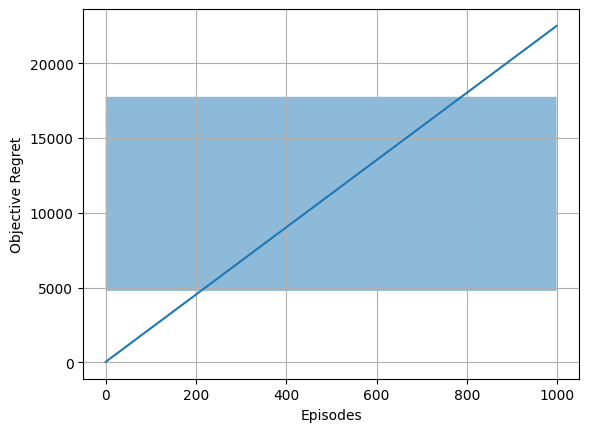

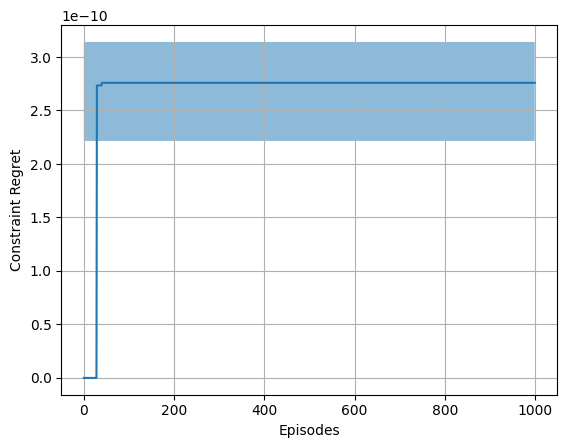

In [8]:
ObjRegret_mean = np.mean(Object_Regret, axis = 0)
ConRegret_mean = np.mean(Cost_Regret, axis = 0)
ObjRegret_std = np.std(Object_Regret, axis = 0)
ConRegret_std = np.std(Cost_Regret, axis = 0)


plt.figure()
plt.plot(range(NUMBER_EPISODES), Object_Regret)
plt.fill_between(range(NUMBER_EPISODES), ObjRegret_mean - ObjRegret_std, ObjRegret_mean + ObjRegret_std, alpha = 0.5)
plt.grid()
plt.xlabel('Episodes')
plt.ylabel('Objective Regret')

plt.show()

plt.figure()
plt.plot(range(NUMBER_EPISODES), Cost_Regret)
plt.fill_between(range(NUMBER_EPISODES), ConRegret_mean - ConRegret_std, ConRegret_mean + ConRegret_std, alpha = 0.5)
plt.grid()
plt.xlabel('Episodes')
plt.ylabel('Constraint Regret')
# plt.title(title)
plt.show()

In [30]:
Object_Regret.shape

(1000,)